In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.65
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K



In [3]:

"""
基本設定
"""
n=210527 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 #36個一組 (3小時一組)
currencynum=5
currency = ["BTC","DASH","ETH","LTC","XMR"]
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
#month = [0,10,20,30,40,50]
month2 = [397,425,456,486,517,547,578,609,639,670,700,731] #2017 365天
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
M=0

# 控制要不要存檔，1 : Yes, 0 : No
save = 1
epochs = 400
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出
btc = 423.51
DASH = 0.00778 * btc
ETH = 0.0021652 * btc
LTC = 0.00805792 * btc
XMR = 0.00105001 * btc


In [4]:


"""
 V
"""
df = pd.read_csv('btc_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
btc5months = np.zeros(n)
for i in range(n):
    btc5months[i] = df[0][i]
df = pd.read_csv('DASH_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
dash5months = np.zeros(n)
for i in range(n):
    dash5months[i] = df[0][i]
df = pd.read_csv('ETH_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
eth5months = np.zeros(n)
for i in range(n):
    eth5months[i] = df[0][i]
df = pd.read_csv('LTC_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
ltc5months = np.zeros(n)
for i in range(n):
    ltc5months[i] = df[0][i]
df = pd.read_csv('XMR_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
xmr5months = np.zeros(n)
for i in range(n):
    xmr5months[i] = df[0][i]    

print('finish dataread')
Train_data=np.zeros(((n-l+1,len(currency),l)))
for p in range(n-l+1):
    Train_data[p,0,:]=btc5months[p:p+l]
    Train_data[p,1,:]=dash5months[p:p+l]
    Train_data[p,2,:]=eth5months[p:p+l]
    Train_data[p,3,:]=ltc5months[p:p+l]
    Train_data[p,4,:]=xmr5months[p:p+l]
    

"""""""""
str, onehotcode, company code轉換
"""""""""


currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)


(210527, 1)
(210527, 1)
(210527, 1)
(210527, 1)
(210527, 1)
finish dataread


In [5]:

"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, condition,typeq):
    # set condition
    def rise_of_fall():
        #目前問題設定只有三種設定：前者大(big)-0、後者大(small)-1、一樣(s)-2
        tmp = np.eye((3))
        d = {0:tmp[0],1:tmp[1],2:tmp[2]}
        return d
    # 拼接問題
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)], rise_of_fall()[condition]))

qtype = ['big','small','same']
HVqtype = ['big','small','same']


"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((5,1))
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])/(btc + np.sum(btc5months[:n]))
    outcome[1]=(data2_sum[1])/(DASH + np.sum(dash5months[:n]))
    outcome[2]=(data2_sum[2])/(ETH + np.sum(eth5months[:n]))
    outcome[3]=(data2_sum[3])/(LTC + np.sum(ltc5months[:n]))
    outcome[4]=(data2_sum[4])/(XMR + np.sum(xmr5months[:n]))

    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(3):
        tmp_q = []
        tmp_a = []
            
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i, all_question[0][0]))
        q_pair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #同漲
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] > outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        else:
             for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] == outcome[str_to_currency(all_cur_pair_P[j][1])] == 0):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)           
        a_pair[i] = tmp_a
        
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((5,1))
    #data_std=np.std(data,axis=1)
    data2_std=np.std(data2,axis=1)    
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
     
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(3):
        tmp_q = []
        tmp_a = []
        
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i,all_question[1][0]))
        q_HVpair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #前者大
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] > outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        else:
             for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] == outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)           
        a_HVpair[i] = tmp_a
        
    return (data, q_HVpair, a_HVpair)


In [6]:

"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = BatchNormalization()(model)
        return model
    return conv

def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


In [7]:

"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(m1*288,m3*288-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:(m2*288-72)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:(m2*288-72)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:(m2*288-72)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[(m2*288)*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[(m2*288)*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[(m2*288)*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    
    """
    算benchmark
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("benchacc:")
    print(benchacc)
    
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='test')
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    


    


g_MLP
drop_out
compile model success
0
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2865 MiB, count=2, average=1433 MiB
[Training model......]
Train on 1568160 samples, validate on 514080 samples
Epoch 1/400
1568160/1568160 [==============================] - 602s 384us/step - loss: 5.8570 - acc: 0.6031 - val_loss: 2.4209 - val_acc: 0.7657
Epoch 2/400
1568160/1568160 [==============================] - 124s 79us/step - loss: 1.5241 - acc: 0.7395 - val_loss: 0.3482 - val_acc: 0.8022
Epoch 3/400
1568160/1568160 [==============================] - 124s 79us/step - loss: 0.4441 - acc: 0.7618 - val_loss: 0.3136 - val_acc: 0.8034
Epoch 4/400
1568160/1568160 [==============================] - 124s 79us/step - loss: 0.3673 - acc: 0.7771 - val_loss: 0.2955 - val_acc: 0.8049
Epoch 5/400
1568160/1568160 [==============================] - 124s 79us/step - loss: 0.3434 - acc: 0.7839 - val_loss: 0.2887 - val_acc: 0.8050
Epoch 6/400
1568160/1568160 [=====================

Epoch 56/400
1568160/1568160 [==============================] - 123s 78us/step - loss: 0.3000 - acc: 0.8023 - val_loss: 0.2865 - val_acc: 0.8055
Epoch 57/400
1568160/1568160 [==============================] - 123s 78us/step - loss: 0.2992 - acc: 0.8027 - val_loss: 0.2845 - val_acc: 0.8058
Epoch 58/400
1568160/1568160 [==============================] - 123s 79us/step - loss: 0.2973 - acc: 0.8034 - val_loss: 0.2856 - val_acc: 0.8055
Epoch 59/400
1568160/1568160 [==============================] - 123s 78us/step - loss: 0.2982 - acc: 0.8045 - val_loss: 0.2859 - val_acc: 0.8112
Epoch 60/400
1568160/1568160 [==============================] - 123s 78us/step - loss: 0.2989 - acc: 0.8041 - val_loss: 0.2851 - val_acc: 0.8112
Epoch 61/400
1568160/1568160 [==============================] - 123s 79us/step - loss: 0.2982 - acc: 0.8030 - val_loss: 0.2860 - val_acc: 0.8055
Epoch 62/400
1568160/1568160 [==============================] - 123s 78us/step - loss: 0.2984 - acc: 0.8042 - val_loss: 0.2862 - v

1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2810 - acc: 0.8106 - val_loss: 0.3002 - val_acc: 0.8082
Epoch 169/400
1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2810 - acc: 0.8106 - val_loss: 0.2997 - val_acc: 0.8083
Epoch 170/400
1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2810 - acc: 0.8105 - val_loss: 0.3012 - val_acc: 0.8085
Epoch 171/400
1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2806 - acc: 0.8100 - val_loss: 0.2998 - val_acc: 0.8082
Epoch 172/400
1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2805 - acc: 0.8105 - val_loss: 0.2993 - val_acc: 0.8085
Epoch 173/400
1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2810 - acc: 0.8105 - val_loss: 0.2999 - val_acc: 0.8089
Epoch 174/400
1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2803 - acc: 0.8103 - val_loss: 0.3022 - val_acc:

1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2581 - acc: 0.8252 - val_loss: 0.3269 - val_acc: 0.8058
Epoch 281/400
1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2580 - acc: 0.8253 - val_loss: 0.3268 - val_acc: 0.8059
Epoch 282/400
1568160/1568160 [==============================] - 122s 77us/step - loss: 0.2578 - acc: 0.8255 - val_loss: 0.3275 - val_acc: 0.8060
Epoch 283/400
1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2575 - acc: 0.8254 - val_loss: 0.3260 - val_acc: 0.8056
Epoch 284/400
1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2575 - acc: 0.8253 - val_loss: 0.3279 - val_acc: 0.8059
Epoch 285/400
1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2574 - acc: 0.8254 - val_loss: 0.3284 - val_acc: 0.8059
Epoch 286/400
1568160/1568160 [==============================] - 122s 78us/step - loss: 0.2571 - acc: 0.8258 - val_loss: 0.3263 - val_acc:

1568160/1568160 [==============================] - 121s 77us/step - loss: 0.2443 - acc: 0.8342 - val_loss: 0.3433 - val_acc: 0.8060
Epoch 393/400
1568160/1568160 [==============================] - 121s 77us/step - loss: 0.2441 - acc: 0.8340 - val_loss: 0.3453 - val_acc: 0.8063
Epoch 394/400
1568160/1568160 [==============================] - 121s 77us/step - loss: 0.2441 - acc: 0.8338 - val_loss: 0.3445 - val_acc: 0.8063
Epoch 395/400
1568160/1568160 [==============================] - 121s 77us/step - loss: 0.2441 - acc: 0.8340 - val_loss: 0.3444 - val_acc: 0.8065
Epoch 396/400
1568160/1568160 [==============================] - 121s 77us/step - loss: 0.2438 - acc: 0.8340 - val_loss: 0.3472 - val_acc: 0.8064
Epoch 397/400
1568160/1568160 [==============================] - 121s 77us/step - loss: 0.2436 - acc: 0.8346 - val_loss: 0.3452 - val_acc: 0.8064
Epoch 398/400
1568160/1568160 [==============================] - 121s 77us/step - loss: 0.2436 - acc: 0.8340 - val_loss: 0.3456 - val_acc:

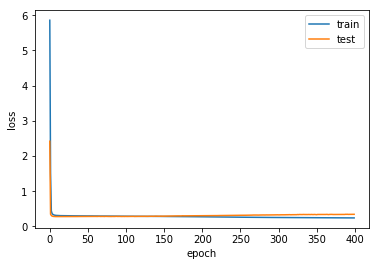

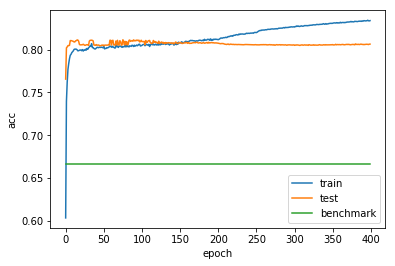

g_MLP
drop_out
compile model success
1
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2865 MiB, count=924, average=3176 KiB
[Training model......]
Train on 2086560 samples, validate on 0 samples
Epoch 1/400
2086560/2086560 [==============================] - 799s 383us/step - loss: 3.2212 - acc: 0.6415
Epoch 2/400
2086560/2086560 [==============================] - 151s 72us/step - loss: 0.4674 - acc: 0.7456
Epoch 3/400
2086560/2086560 [==============================] - 150s 72us/step - loss: 0.3552 - acc: 0.7826
Epoch 4/400
2086560/2086560 [==============================] - 150s 72us/step - loss: 0.3216 - acc: 0.7969
Epoch 5/400
2086560/2086560 [==============================] - 150s 72us/step - loss: 0.3062 - acc: 0.8042
Epoch 6/400
2086560/2086560 [==============================] - 149s 72us/step - loss: 0.2987 - acc: 0.8073
Epoch 7/400
2086560/2086560 [==============================] - 149s 71us/step - loss: 0.2948 - acc: 0.8091
Epoch 8/400
2086560/2086

KeyboardInterrupt: 

In [8]:


for i in range(0,20,1):

    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,6)(visual_scene)
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((15,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(4, get_dense(4,MLP_unit))
    f_MLP = get_MLP(4, get_dense(4,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(i)
    fit_show(Train_data,month[i],month[i+3],month[i+4])